# Buoy Drift Residual Analysis

In [44]:
import cartopy
import cv2
import cmocean
import cftime
from datetime import datetime, timedelta
import numpy as np
import netCDF4 as nc
import pandas as pd
import pyproj as proj
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.dates as mdates
import metpy.calc as mpcalc
from scipy import io, interpolate, stats, signal

%matplotlib widget

In [45]:
# Helping Functions
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

In [59]:
# Add the wave gliders back in
df = pd.read_csv('../data/play1_df.csv')
df = df.dropna(subset=['hs', 'drift_direction', 'drift_speed', 'windspd', 'winddir'])

# Get SWIFT Numbers to Investigate
print(df['swiftnum'].unique())
datetimes = pd.to_datetime(df['time'][:])

# Look at Available Data
df.head()

[12. 13. 15. 16. 17.]


,Unnamed: 0,time,latitude,longitude,hs,wave_direction,wave_direction_mathconv,drift_speed,drift_direction,instrument_type,...,salinity,water_temperature,swell_height,swell_direction,x cartesian,y cartesian,EW_drift_speed,NS_drift_speed,EW_wind_speed,NS_wind_speed
1,1,2022-09-09 21:36:00.000002,72.587006,-149.976730,0.939075,49.847000,220.153000,0.554840,285.247159,SWIFT,...,24.324784,-0.027654,0.593020,146.648194,37532.052769,12291.923473,-0.535310,0.145914,-7.086799,-7.581975
2,2,2022-09-09 21:48:00.000000,72.587936,-149.988266,0.945042,80.848877,189.151123,0.554722,286.136217,SWIFT,...,24.329163,-0.000189,0.539638,153.383845,37144.731433,12388.604995,-0.532868,0.154169,-7.693642,-7.011761
3,3,2022-09-09 21:59:59.999996,72.589012,-149.999924,0.934823,110.630768,159.369232,0.565919,287.676971,SWIFT,...,24.339722,0.006934,0.580278,150.234016,36753.074440,12501.460282,-0.539198,0.171841,-6.992538,-7.639747
4,4,2022-09-09 22:12:00.000004,72.590172,-150.011734,0.977387,104.254364,165.745636,0.581481,289.020320,SWIFT,...,24.349068,0.020668,0.589944,151.827992,36356.195920,12623.663395,-0.549734,0.189507,-7.087295,-7.247516
5,5,2022-09-09 22:24:00.000002,72.591476,-150.023849,0.903661,115.809448,154.190552,0.582531,290.030663,SWIFT,...,24.362905,0.034725,0.476362,156.379736,35948.883623,12761.936160,-0.547294,0.199530,-8.222215,-6.723323


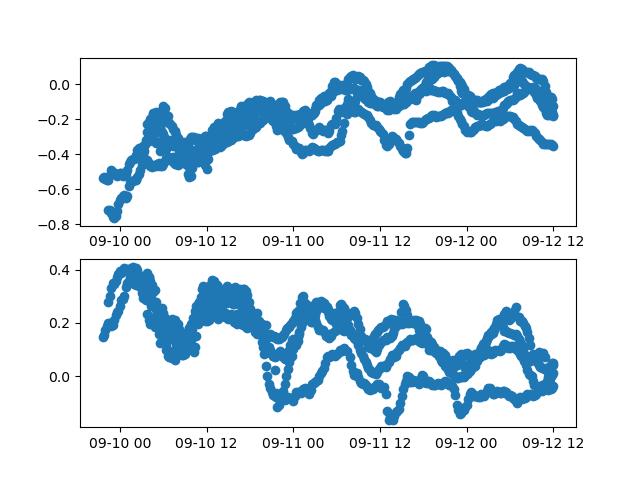

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.scatter(datetimes, df['EW_drift_speed'])
ax2.scatter(datetimes, df['NS_drift_speed'])

Text(0, 0.5, 'Drift Speed Magnitude [m/s]')

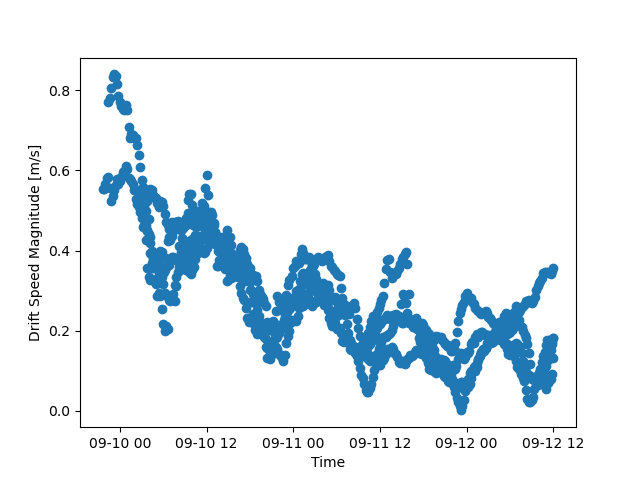

In [57]:
fig, ax = plt.subplots()
ax.scatter(datetimes, df['drift_speed'])
ax.set_xlabel('Time')
ax.set_ylabel('Drift Speed Magnitude [m/s]')

Text(0, 0.5, 'Drift Direction [degrees from north - toward]')

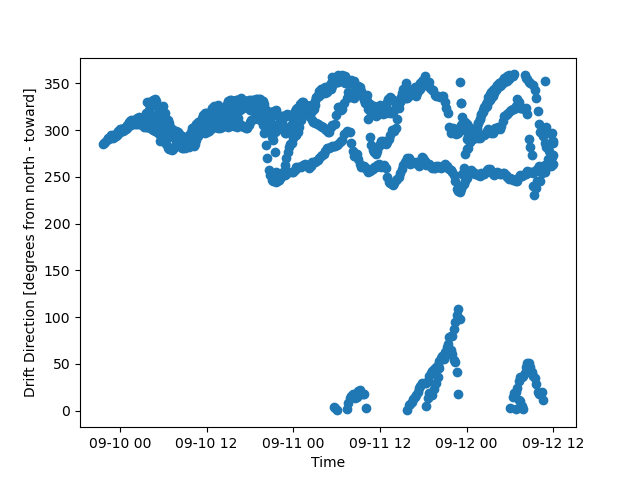

In [58]:
fig, ax = plt.subplots()
ax.scatter(datetimes, df['drift_direction'])
ax.set_xlabel('Time')
ax.set_ylabel('Drift Direction [degrees from north - toward]')

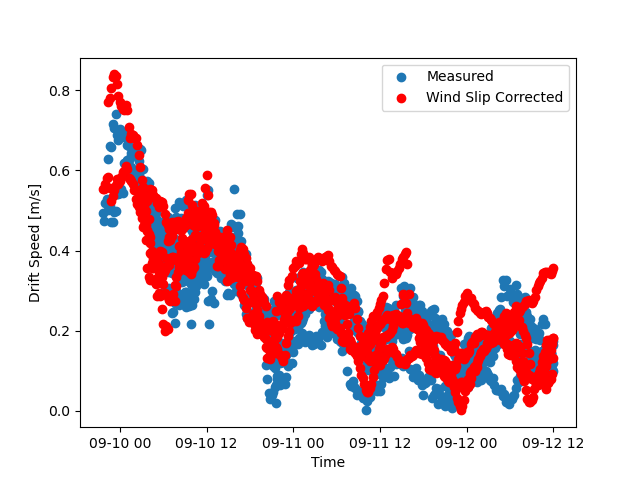

In [75]:
# Subtract the Direct Windage from the Drift
# wind_drift_factor = 0.0109
wind_drift_factor = 0.03
ew_drift_wind_corrected = df['EW_drift_speed'] - (wind_drift_factor * df['EW_wind_speed'])
ns_drift_wind_corrected = df['NS_drift_speed'] - (wind_drift_factor * df['NS_wind_speed'])

# Compute Magnitude and Direction
mag_drift_wind_corrected = np.sqrt(ew_drift_wind_corrected**2 + ns_drift_wind_corrected**2)
direction_drift_wind_corrected = np.rad2deg(np.arctan2(ns_drift_wind_corrected, ew_drift_wind_corrected))

fig, ax1 = plt.subplots()
ax1.scatter(datetimes, mag_drift_wind_corrected, label='Measured')
ax1.scatter(datetimes, df['drift_speed'], color='red', label='Wind Slip Corrected')
ax1.set_xlabel('Time')
ax1.set_ylabel('Drift Speed [m/s]')
ax1.legend()

# ax2.scatter(datetimes, direction_drift_wind_corrected, label='Measured')
# ax2.scatter(datetimes, df['drift_direction'], color='red', label='Wind Slip Corrected')
# ax2.set_xlabel('Time')
# ax2.set_ylabel('Drift Direction [Degrees from North ]')
# ax2.legend()

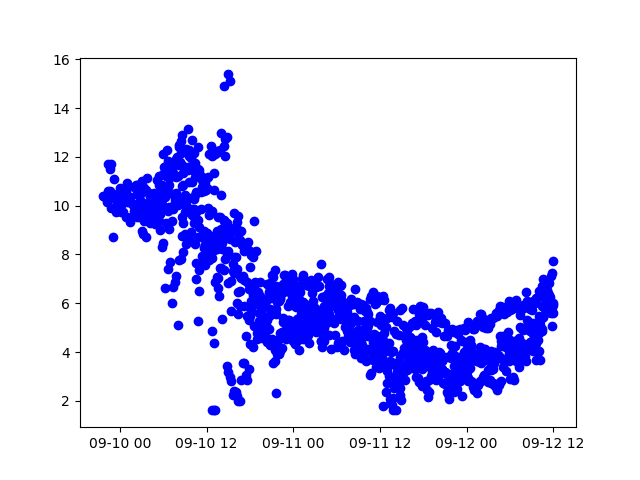

In [49]:
fig, ax = plt.subplots()
ax.scatter(datetimes, df['windspd'], color='blue')
# ax.twinx()
# ax2.scatter(datetimes, df['drift_speed'], color='red')

Text(0, 0.5, 'Drift Direction [degrees - toward]')

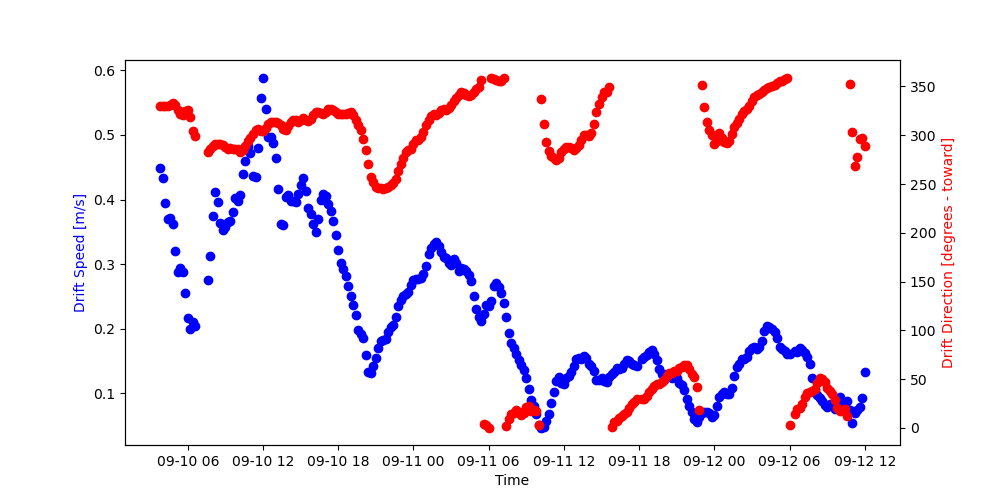

In [50]:
df_swift = df[df['swiftnum'] == 13]
swift_datetimes = pd.to_datetime(df_swift['time'][:])

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(swift_datetimes, df_swift['drift_speed'], color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('Drift Speed [m/s]', color='blue')
ax2 = ax.twinx()
ax2.scatter(swift_datetimes, df_swift['drift_direction'], color='red')
ax2.set_ylabel('Drift Direction [degrees - toward]', color='red')


Text(0, 0.5, 'Wind Speed [m/s]')

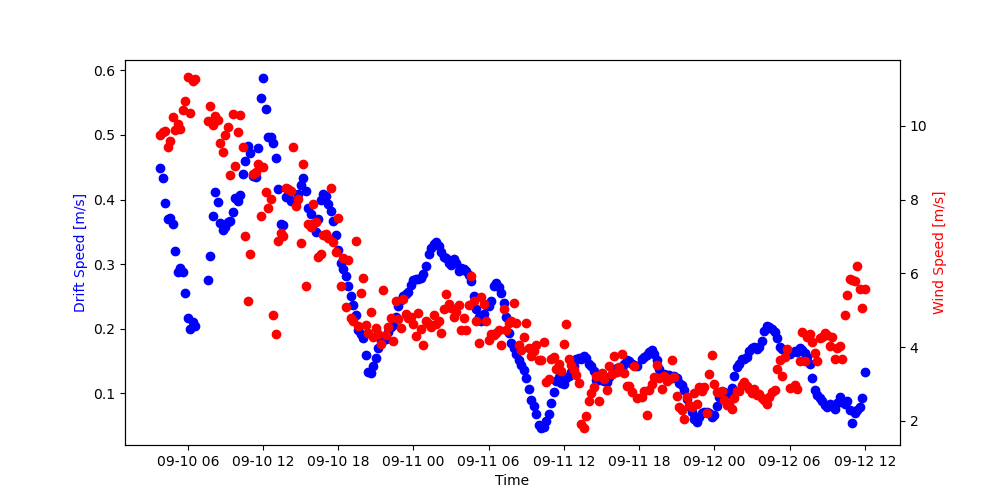

In [51]:
# lets look at this buoy's wind speed and direction that it measured 
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(swift_datetimes, df_swift['drift_speed'], color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('Drift Speed [m/s]', color='blue')
ax2 = ax.twinx()
ax2.scatter(swift_datetimes, df_swift['windspd'], color='red')
ax2.set_ylabel('Wind Speed [m/s]', color='red')


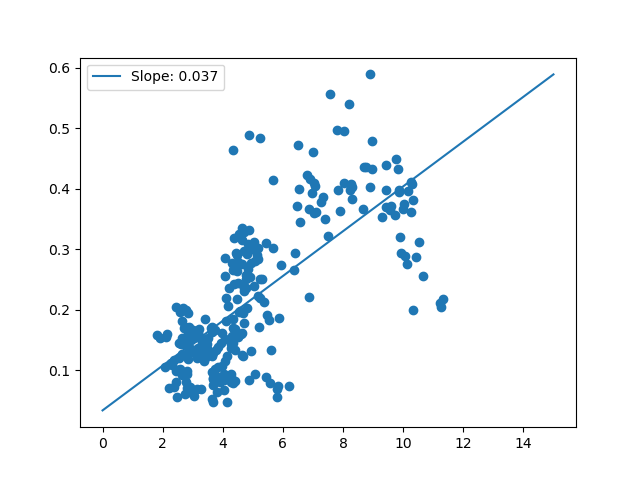

In [52]:
# Correlation between the wind speed and drift speed
fig, ax = plt.subplots()
ax.scatter(df_swift['windspd'], df_swift['drift_speed'])
slope, intercept = np.polyfit(df_swift['windspd'], df_swift['drift_speed'], 1)
ax.plot(np.linspace(0, 15), np.linspace(0, 15)*slope + intercept, label=f'Slope: {np.round(slope, 4)}')
ax.legend()


Could there be a trend in the residual with distance in and out of ice? 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


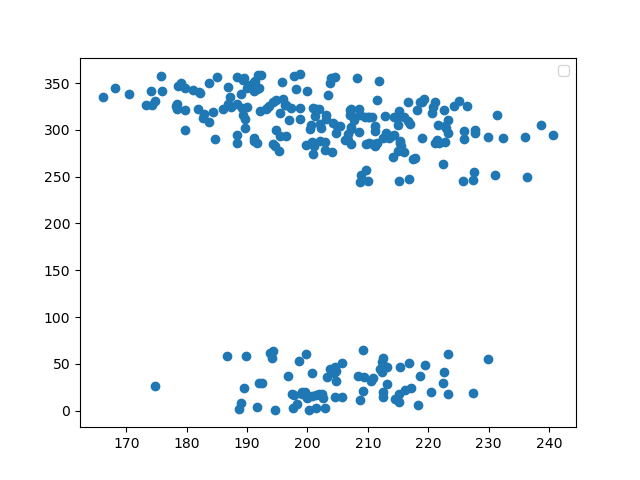

In [53]:
# Correlation between the Wind Direction and Drift Direction
fig, ax = plt.subplots()
ax.scatter((270-df_swift['winddir'])%360, df_swift['drift_direction'])
slope, intercept = np.polyfit((270-df_swift['winddir'])%360, df_swift['drift_speed'], 1)
# ax.plot(np.linspace(0, 15), np.linspace(0, 15)*slope + intercept, label=f'Slope: {np.round(slope, 4)}')
ax.legend()


Not sure what to make of this - May come back to it later.

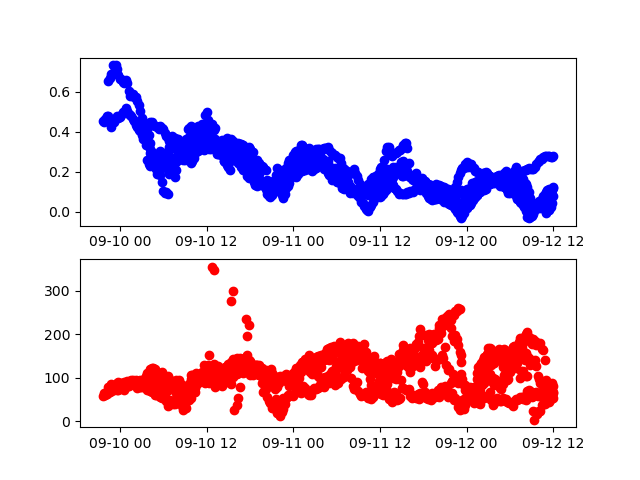

In [54]:
# Compute Wind Drift Residual of Magnitude and Direction
wind_drift_speed_residual = df['drift_speed'] - (df['windspd'] * 0.01)
wind_drift_dir_residual = (df['drift_direction'] - (270-df['winddir']))%360

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.scatter(datetimes, wind_drift_speed_residual, color='blue')
ax2.scatter(datetimes, wind_drift_dir_residual, color='red')


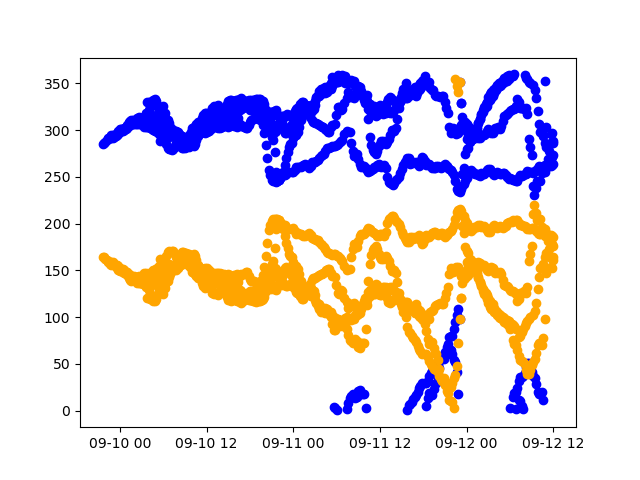

In [55]:
fig, ax = plt.subplots()
ax.scatter(datetimes, df['drift_direction'], color='blue')

math_conv_drift_dir = ((450 - df['drift_direction'])%360)
ax.scatter(datetimes, math_conv_drift_dir, color='orange')

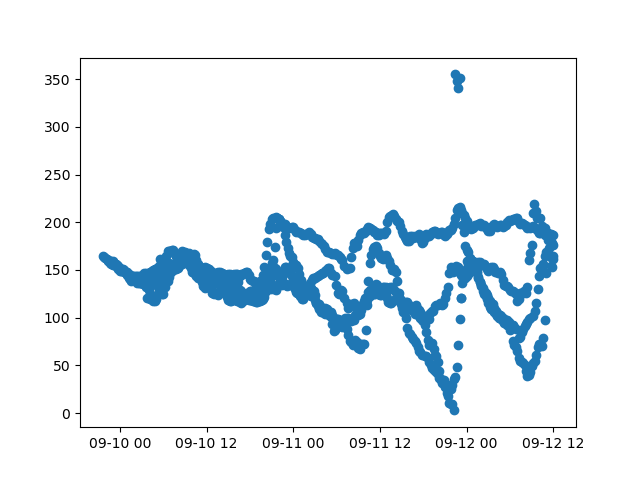

In [56]:
def navigation_angle2math_angle(angle, convention='toward'):
    if convention == 'toward':
        math_angle = (450 - angle) % 360
    if convention == 'from':
        angle_toward = (angle + 180) % 360
        math_angle = (450 - angle_toward) % 360
    return math_angle

drift_dir_math_conv_test = navigation_angle2math_angle(df['drift_direction'], convention='toward')
fig, ax = plt.subplots()
ax.scatter(datetimes, drift_dir_math_conv_test)